In [4]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, confusion_matrix
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier


In [5]:

# Establish a connection to the database
conn = psycopg2.connect(
    host="localhost",
    database="ProjetBI",
    user="postgres",
    password="marwa"
)

In [6]:
# Create a cursor object
cur = conn.cursor()

# Execute the SQL query
cur.execute("SELECT stats.\"Job_Duration\", stats.\"Data_Volume\", (select count(\"Component_PK\") from public.\"DimJob\" join public.\"DimComponent\" on(public.\"DimJob\".\"Job_PK\" = public.\"DimComponent\".\"Job_FK\") where \"Job_PK\"=stats.\"Job_FK\" group by \"Job_Code\") as \"Nbr_Components\" FROM public.\"FactStats\" stats")
# Fetch all the rows as a list of tuples
rows = cur.fetchall()

# Convert the list of tuples to a pandas DataFrame
df = pd.DataFrame(rows, columns=["Job_Duration","Data_Volume", "Nbr_Components"])
print(df)



       Job_Duration  Data_Volume  Nbr_Components
0             33447        39387               9
1             33447        39600               9
2             33447        39593               9
3             33447        39680               9
4             33447        41401               9
...             ...          ...             ...
11843         20993         3553               5
11844         20993         3554               5
11845         20993         3512               5
11846         20993         3482               5
11847         20993         3458               5

[11848 rows x 3 columns]


In [4]:
# normalize the data
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
print(df)


       Job_Duration  Data_Volume  Nbr_Components
0          1.000000     0.388254        1.000000
1          1.000000     0.390353        1.000000
2          1.000000     0.390284        1.000000
3          1.000000     0.391142        1.000000
4          1.000000     0.408107        1.000000
...             ...          ...             ...
11843      0.199666     0.035014        0.333333
11844      0.199666     0.035024        0.333333
11845      0.199666     0.034610        0.333333
11846      0.199666     0.034314        0.333333
11847      0.199666     0.034078        0.333333

[11848 rows x 3 columns]


# CAH : Segmentation des jobs

In [5]:
# CAH dendogramme
Z = linkage(df, method='ward')
dendrogram(Z)
plt.show()


In [6]:
#segmentation
y_pred = AgglomerativeClustering(n_clusters= 3, affinity='euclidean', linkage='ward').fit_predict(df)


C:\Users\msi\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [7]:
# Assignation des jobs à des clusters
df['Cluster'] = y_pred

# Affichage des résultats
print(df.head())

   Job_Duration  Data_Volume  Nbr_Components  Cluster
0           1.0     0.388254             1.0        1
1           1.0     0.390353             1.0        1
2           1.0     0.390284             1.0        1
3           1.0     0.391142             1.0        1
4           1.0     0.408107             1.0        1


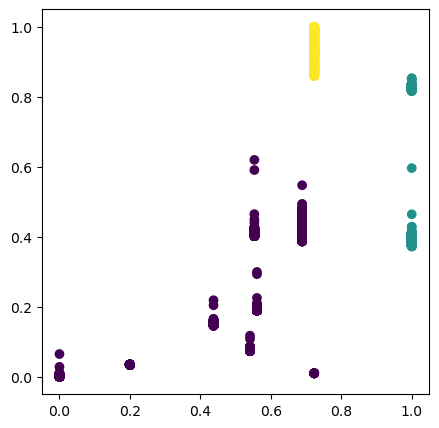

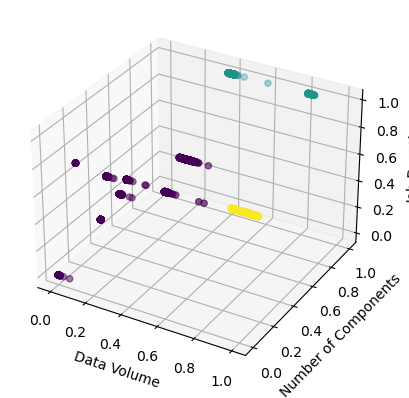

In [8]:
# Graphique des résultats
plt.figure(figsize=(5, 5))
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=y_pred)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['Data_Volume'], df['Nbr_Components'], df['Job_Duration'], c=df['Cluster'], cmap='viridis')
ax.set_xlabel('Data Volume')
ax.set_ylabel('Number of Components')
ax.set_zlabel('Job Duration')
plt.show()

# Random Forest : Classification des jobs


In [9]:
#Pour éviter Overfitting
df=df.sample(n=4000,random_state=42)

In [10]:
df
#Train and test division
X2 = df.iloc[:,:-1]
y2 = df.iloc[:,-1]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=0)

In [11]:
#initialisation et entrainement du modèle
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(X_train2, y_train2)

RandomForestClassifier(random_state=0)

In [12]:
#Test and accuracy
y_pred2 = rf_model.predict(X_test2)

In [13]:
#Accuracy and confusion matrix
r2_random_forest = r2_score(y_test2, y_pred2)
print("R² : ",r2_random_forest)

accuracy_random_forest = accuracy_score(y_test2, y_pred2)
print("Accuracy:", accuracy_random_forest)

conf_mat=confusion_matrix(y_test2, y_pred2)
conf_mat

R² :  1.0
Accuracy: 1.0


array([[898,   0,   0],
       [  0, 141,   0],
       [  0,   0, 161]], dtype=int64)

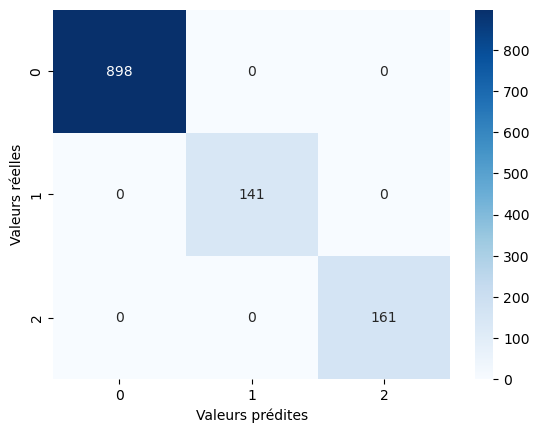

In [14]:
# Visualiser la matrice de confusion sous forme de graphique
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.show()

# Arbre de décision : Classification des jobs 


In [186]:
#Pour éviter Overfitting
df=df.sample(n=4000,random_state=42)

In [187]:
# Diviser le dataframe en un ensemble d'entraînement et un ensemble de test
X_train, X_test, y_train, y_test = train_test_split(df[['Data_Volume','Nbr_Components','Job_Duration']], df['Cluster'], test_size=0.2, random_state=42)

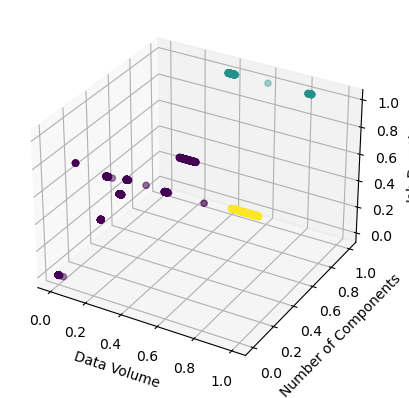

In [188]:
# create a scatter plot of the test data

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train['Data_Volume'], X_train['Nbr_Components'], X_train['Job_Duration'], c=y_train, cmap='viridis')
ax.set_xlabel('Data Volume')
ax.set_ylabel('Number of Components')
ax.set_zlabel('Job Duration')
plt.show()

In [192]:
# Entraîner un modèle d'arbre de décision sur l'ensemble d'entraînement
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = dt.predict(X_test)

# Évaluer la précision du modèle
r2 = r2_score(y_test, y_pred)
print("R² : ",r2)

accuracy = accuracy_score(y_test, y_pred)
print(f'La précision du modèle est de {accuracy:.2%}')

#matrice de confusion = classification
cm = confusion_matrix(y_test, y_pred)
print(cm)

R² :  0.997079769739844
La précision du modèle est de 99.88%
[[627   0   0]
 [  0  88   1]
 [  0   0  84]]


avec une précision de 99,88%, ce qui indique qu'il est capable de classer avec précision les données en trois catégories distinctes. La matrice de confusion fournie montre que le modèle n'a fait aucune erreur pour les deux premières catégories et une seule erreur pour la troisième catégorie.

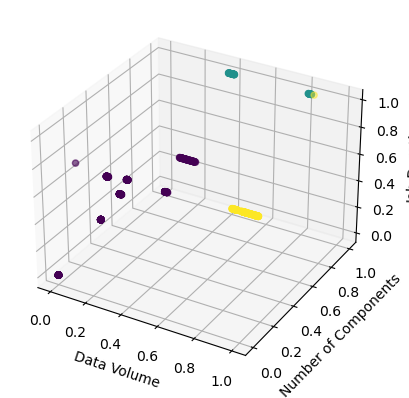

In [190]:
# Visualisation des données prédites
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test['Data_Volume'], X_test['Nbr_Components'], X_test['Job_Duration'], c=y_pred)
ax.set_xlabel('Data Volume')
ax.set_ylabel('Number of Components')
ax.set_zlabel('Job Duration')
plt.show()